# Covid Model
## Reading Data
We are using the Kaggle dataset Covid 19 Radiography Dataset and we store the information read to avoid reading it again everytime.

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf

DIRECTORY = '/home/hivini/learn/research/new-covid/'
DATASET_FOLDER = DIRECTORY + 'COVID-19_Radiography_Dataset'
IMG_SIZE = 150

def readImages(files, name):
    if os.path.exists(name):
        return np.load(name, allow_pickle=True)
    data = []
    for path_im in files:
        try:
            img_arr = cv2.imread(path_im, cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            data.append(resized_arr) # Reshaping images to preferred size
        except Exception as e:
            print(e)
    arr = np.array(data, dtype='object')
    np.save(name, arr)
    return arr


covid_filenames = tf.io.gfile.glob(DATASET_FOLDER + '/COVID/*')
normal_filenames = tf.io.gfile.glob(DATASET_FOLDER + '/Normal/*')
covid_images = readImages(covid_filenames, DIRECTORY + 'cxr_covid.npy')
normal_images = readImages(normal_filenames, DIRECTORY + 'cxr_normal.npy')
# Taking the easy way out.
# TODO(hivini): Is better to inflate the other Covid Dataset.
normal_images = normal_images[:covid_images.shape[0]]
print(covid_images.shape)
print(normal_images.shape)

2021-09-23 22:19:12.284350: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(3616, 150, 150)
(3616, 150, 150)


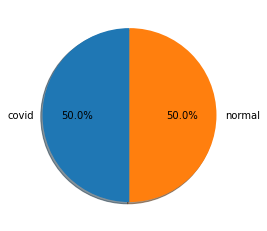

In [2]:
import matplotlib.pyplot as plt
#Plotting Distribution of Each Classes
image_count = {'covid': covid_images.shape[0], 'normal': normal_images.shape[0]}
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

## Separate the training and test data.

In [3]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

covid_labels = np.ones(covid_images.shape[0])
normal_labels = np.zeros(normal_images.shape[0])
all_images = np.concatenate((covid_images, normal_images))
all_labels = np.concatenate((covid_labels, normal_labels))
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.20)
train_images = train_images.reshape((train_images.shape[0], IMG_SIZE, IMG_SIZE, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((test_images.shape[0], IMG_SIZE, IMG_SIZE, 1))
test_images = test_images.astype('float32') / 255

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(5785, 150, 150, 1)
(5785,)
(1447, 150, 150, 1)
(1447,)


In [4]:
print(train_labels)

[1. 1. 0. ... 0. 0. 1.]


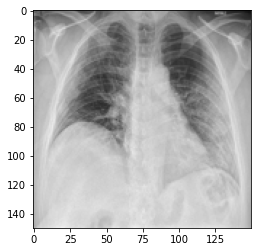

In [5]:
plt.clf()
plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_GRAY2RGB))
plt.show()

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

2021-09-23 22:19:34.317499: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 22:19:34.338827: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-23 22:19:34.940612: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-09-23 22:19:34.941066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.215GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2021-09-23 22:19:34.941150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-23 22:19:34.997784: I tensorflow/stre

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [7]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
history = model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(test_images, test_labels))
model.save(DIRECTORY + 'covid_model_result.h5')
test_loss, test_acc = model.evaluate(test_images, test_labels)

(5785, 150, 150, 1)
(5785,)
(1447, 150, 150, 1)
(1447,)


2021-09-23 22:19:37.627641: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520650000 exceeds 10% of free system memory.
2021-09-23 22:19:38.121804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-23 22:19:38.127821: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2208005000 Hz


Epoch 1/30


2021-09-23 22:19:39.659876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-23 22:19:40.187262: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-09-23 22:19:45.163129: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-09-23 22:19:45.359317: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


58/58 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.6019

2021-09-23 22:20:56.577625: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 130230000 exceeds 10% of free system memory.


58/58 [==============================] - 95s 1s/step - loss: 0.6674 - accuracy: 0.6027 - val_loss: 0.5611 - val_accuracy: 0.7139
Epoch 2/30
58/58 [==============================] - 4s 74ms/step - loss: 0.5552 - accuracy: 0.7179 - val_loss: 0.5248 - val_accuracy: 0.7270
Epoch 3/30
58/58 [==============================] - 4s 71ms/step - loss: 0.4698 - accuracy: 0.7704 - val_loss: 0.4466 - val_accuracy: 0.7975
Epoch 4/30
58/58 [==============================] - 4s 69ms/step - loss: 0.4159 - accuracy: 0.8105 - val_loss: 0.4203 - val_accuracy: 0.8003
Epoch 5/30
58/58 [==============================] - 4s 65ms/step - loss: 0.3808 - accuracy: 0.8294 - val_loss: 0.4726 - val_accuracy: 0.7878
Epoch 6/30
58/58 [==============================] - 4s 65ms/step - loss: 0.3504 - accuracy: 0.8463 - val_loss: 0.3450 - val_accuracy: 0.8556
Epoch 7/30
58/58 [==============================] - 4s 66ms/step - loss: 0.3134 - accuracy: 0.8711 - val_loss: 0.3378 - val_accuracy: 0.8735
Epoch 8/30
58/58 [=======

2021-09-23 22:23:09.546228: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 130230000 exceeds 10% of free system memory.


46/46 [==============================] - 26s 292ms/step - loss: 0.3128 - accuracy: 0.8749


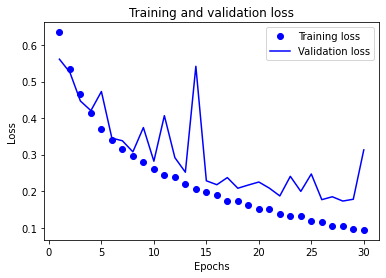

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# bo is for blue dot.
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

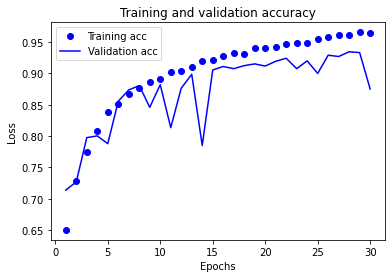

In [10]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()